In [174]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from nn_robust_attacks.l2_attack import CarliniL2
from nn_robust_attacks.setup_mnist import MNIST, MNISTModel

In [175]:
sess = tf.Session(config=tf.ConfigProto())
K.set_session(sess)

data = MNIST()

class MNIST_Model:
    def __init__(self, session=None):
        self.num_channels = 1
        self.image_size = 28
        self.num_labels = 10

        model = Sequential()

        model.add(Conv2D(32, (3, 3),
                         input_shape=(28, 28, 1)))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(200))
        model.add(Activation('relu'))
        model.add(Dense(200))
        model.add(Activation('relu'))
        model.add(Dense(10))

        self.model = model

    def predict(self, data):
        return self.model(data)

In [176]:
num_epochs = 5
batch_size = 128
train_temp = 1

training = False

In [177]:
from keras.models import load_model

def fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                   logits=predicted/train_temp)

# Train first model 
modelname = "models/trained_model1"
model1 = MNIST_Model()
if training:            
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model1.model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    model1.model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              nb_epoch=num_epochs,
              shuffle=True)
    
    model1.model.save(modelname)
    
else:
    model1.model = load_model(modelname, custom_objects={'fn':fn})
        
model1.model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_73 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_74 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_75 (Activation)   (None, 10, 10, 64)      

In [178]:
# Train second model 
modelname = "models/trained_model2"
if training:
    model2 = MNIST_Model()
            
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model2.model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    model2.model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              nb_epoch=num_epochs,
              shuffle=True)
    
    model2.model.save(modelname)
    
else:
    model2.model = load_model(modelname, custom_objects={'fn':fn})
    
model2.model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_79 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_80 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_81 (Activation)   (None, 10, 10, 64)      

In [179]:
# Pernn_robust_attacks of first model
scores = model1.model.evaluate(x_test, y_test)
print("loss={}, accuracy={}".format(*scores))

10000/10000 [==============================] - 2s 203us/step
loss=0.24138298530429603, accuracy=0.9215999841690063


In [180]:
# Performance of second model
scores = model2.model.evaluate(x_test, y_test)
print("loss={}, accuracy={}".format(*scores))

10000/10000 [==============================] - 2s 205us/step
loss=0.1333903110517189, accuracy=0.9563000202178955


In [186]:
attack = CarliniL2(sess, 
                   model1,
                   max_iterations=1000, 
                   confidence=0,
                   model2=model2)

TypeError: __init__() got an unexpected keyword argument 'model2'

In [131]:
def generate_data(data, samples, targeted=True, start=0, inception=False):
    """
    Generate the input data to the attack algorithm.
    data: the images to attack
    samples: number of samples to use
    targeted: if true, construct targeted attacks, otherwise untargeted attacks
    start: offset into data to use
    inception: if targeted and inception, randomly sample 100 targets intead of 1000
    """
    inputs = []
    targets = []
    for i in range(samples):
        if targeted:
            if inception:
                seq = random.sample(range(1,1001), 10)
            else:
                #seq = range(data.test_labels.shape[1])
                seq = range(1)

            for j in seq:
                if (j == np.argmax(data.test_labels[start+i])) and (inception == False):
                    continue
                inputs.append(data.test_data[start+i])
                targets.append(np.eye(data.test_labels.shape[1])[j])
        else:
            inputs.append(data.test_data[start+i])
            targets.append(data.test_labels[start+i])

    inputs = np.array(inputs)
    targets = np.array(targets)

    return inputs, targets


inputs, targets = generate_data(data, 
                                samples=1, 
                                targeted=True, 
                                start=0, 
                                inception=False)

Target 0


<Figure size 432x288 with 0 Axes>

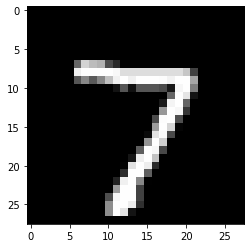

In [166]:
inp = inputs[0][:, :, 0]
plt.set_cmap('Greys_r')
plt.figure()
plt.imshow(inp)
print('Target', np.where(targets[0]==1)[0][0])

In [161]:
adv = CarliniL2(sess, model1).attack(inputs, targets)

go up to 1
tick 0
[10000000000.0]
0 (0.021236112, 0.020300826, 0.0009352869)
1000 (0.02035297, 0.020350194, 2.7775473e-06)
2000 (0.020353276, 0.02034866, 4.616304e-06)
[10000000000.0]
0 (0.20396885, 0.20300537, 0.00096348237)
1000 (0.20312768, 0.20269905, 0.00042863574)
2000 (0.20311886, 0.20267265, 0.00044622264)
[10000000000.0]
0 (2.0310178, 2.030051, 0.0009667443)
1000 (1.9872005, 1.9346455, 0.05255501)
2000 (1.9871924, 1.9346651, 0.052527353)
[10000000000.0]
0 (20.301468, 20.3005, 0.00096708065)
1000 (8.163737, 0.016043663, 8.147694)
2000 (8.158071, 0.031826735, 8.126244)
3000 (8.160954, 0.0425272, 8.118427)
[8.14546]
0 (11.166243, 11.165276, 0.00096704916)
1000 (9.22063, 6.750702, 2.4699278)
2000 (9.220194, 6.7490997, 2.4710937)
[8.14546]
0 (15.733856, 15.732889, 0.0009670692)
1000 (8.16138, 0.030899636, 8.13048)
2000 (8.179038, 0.14667317, 8.032365)
[8.14546]
0 (13.45005, 13.449083, 0.0009670607)
1000 (8.169632, 0.19052571, 7.979106)
2000 (8.160476, 0.1810887, 7.979387)
3000 (8.1

Valid:


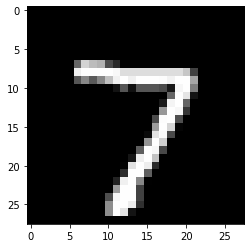

In [167]:
print("Valid:")
plt.imshow(inputs[i][:,:,0])

Adversarial:


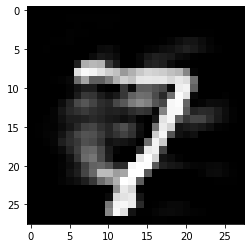

In [168]:
print("Adversarial:")
plt.imshow(adv[i][:,:,0])